<h1>Análisis de espectros de emisión por medio de redes neuronales de clasificación</h1>
<h3>Resumen:</h3>
<p>Se realizaron predicciones sobre datos experimentales a partir de valores tabulados. La información de estos valores tabulados (dataset de entrenamiento) puede obtenerse a partir del siguiente link:</p>
<a href="https://physics.nist.gov/PhysRefData/ASD/lines_form.html">Sitio web de datos tabulados.</a>
<p>El objetivo es analizar la eficiencia de una red de clasificación para predecir el elemento al cual pertenecen ciertos picos experimentales, variando parámetros como el número de datos tabulados por elemento y las épocas al entrenar el modelo. <br>
Una vez determinada la configuración óptima para entrenar el modelo de clasificación, se realizaron predicciones y se graficó una matriz de confusión para observar los aciertos de la red. También se obtuvo un reporte con información de las predicciones, como la precisión, el recall score y el f1 score.</p>

<h1>Funciones, clases y librerías</h1>

In [2]:
#Librerías
import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import seaborn as sns

In [3]:
#Funciones
#1) esta función es para hallar los principales picos tabulados para un elemento
def espectral_main_peaks(n_peaks,x,y):
    #Creamos dos listas con los valores de x e y pero por cada máximo, quitamos ese valor
    x_p=x
    y_p=y

    #Aquí guardamos los valores de los picos
    peaks_x=[]
    peaks_y=[]
    for i in range(n_peaks):
        max_index=np.argmax(y_p)
        #agregamos el máximo en la otra lista
        peaks_x.append(x_p[max_index])
        peaks_y.append(y_p[max_index])
        #eliminamos ese máximo en x_p,y_p
        x_p,y_p = np.delete(x_p,max_index),np.delete(y_p,max_index)

    #Esta función devuelve los picos
    return peaks_x,peaks_y

#2) esta función determina los picos experimentales mediante find_peaks
def experimental_peaks(lamb,I,list_peaks,elem,h,d,p):
    lp,Ip,yp=list_peaks
    #Parámetros de control: altura mínima "h", distancia entre picos "d", prominencia del pico "p"
    index,_ =find_peaks(I, height=h, distance=d, prominence=p)

    lp.extend(lamb[index])
    Ip.extend(I[index])
    yp.extend([elem]*len(lamb[index]))
    return lp,Ip,yp

#3) esta función limpia los datos no numéricos de los espectros experimentales
def clean_espectral_data(file):
    #48 filas del csv del espectro contienen información no relevante
    data=pd.read_csv(file, skiprows=48, sep=';', names=['lambda','I'])
    #Eliminamos la última fila, pues no aporta información numérica
    data=data.iloc[:-1]

    #Obtenemos los arrays de la longitud de onda y la intensidad
    lamb=np.array(np.float64(data['lambda'].values)) #La primera columna contiene números en formato de texto
    I=np.array(data['I'].values)


    return lamb,I

#4) esta función, además de hallar los picos tabulados principales en 1), extiende una lista con esos valores y sus etiquetas
def peak_extraction(r1,r2,list_elem,list_columns,n_peaks):
    #Listas que van a almacenar los picos
    l,Ir,y=list_columns
    folder_train="dataset espectroscopia/dataset train/"
    
    #Realizamos la extracción de datos por cada elemento de la lista
    for elem in list_elem:
        data=pd.read_excel(folder_train + f"Picos emision {elem}.xlsx")
        
        lrow=pd.to_numeric(data.iloc[:,r1],errors='coerce')
        Irow=pd.to_numeric(data.iloc[:,r2],errors='coerce')


        #Recorremos los valores de las columnas para obtener los datos relevantes
        lamb=[]
        Irel=[]
        for i in range(len(lrow)):
            #Verificación de datos NaN
            if (np.isnan(lrow[i]) or np.isnan(Irow[i])):
                continue
            else:

                #El rango de longitudes de onda será de 200nm a 1100nm (similar a los datos de prueba)
                if (lrow[i]>200 and lrow[i]<1100):
            
                    lamb.append(lrow[i])
                    #Algunos valores de I son negativos, por lo que se debe de tomar módulo
                    Irel.append(abs(Irow[i]))
    

        #Se deben normalizar los datos de intensidad dividiendo por el máximo
        Irel/=max(Irel)

        #Tomamos el número de picos necesario para el entrenamiento (se usa la función de 1))
        lamb_main,Irel_main=espectral_main_peaks(n_peaks,lamb,Irel)
        l.extend(lamb_main)
        Ir.extend(Irel_main)
        y.extend([elem]*len(lamb_main))

    #Verificación de los picos extraídos mediante un print
    print("Número total de picos extraídos:",len(l))
    
    return l,Ir,y


#5) función de escalado de datos "X", y codificación de datos "y"
def scaler(l,Ir,y):
    X_train=np.column_stack((l, Ir))
    sc_X=StandardScaler()
    X_train=sc_X.fit_transform(X_train)
    le = LabelEncoder()
    y_train = le.fit_transform(y)

    #Verificación por medio de un print
    print(f"Finalizado el escalado de datos. X_train.shape={X_train.shape}")

    #Returneamos los datos de entrenamiento y las funciones de escalado y codificación "sc_X" y "le"
    return X_train,y_train,sc_X,le

#6) función para realizar el escalado y codificación de los datos de prueba
def scaler_test(l,Ir,y,sc,le):
    X_test=np.column_stack((l, Ir))
    X_test=sc.fit_transform(X_test)
    y_test = le.transform(y)

    #Verificación por medio de un print
    print(f"Finalizado el escalado de datos. X_test.shape={X_test.shape}")

    #Returneamos los datos de prueba y las funciones de escalado y codificación "sc" y "le"
    return X_test,y_test,sc,le

In [116]:
#Modelo de red neuronal de clasificación
class ClassifierNetwork:

    #Parámetros de control de la red:
    #Entrada: input_dim, units, kernel_initializer, activation
    #Capas ocultas: cantidad, units, kernel_initializer, activation, dropout
    #Salida: units, kernel_initializer, activation
    #Compilación: optimizer, loss, metrics
    #Fit: X_train, y_train, batch_size, epochs, validation_split, verbose
    #Predict: X_test, y_test
    def __init__(self, input_par, hide_par, output_par, comp_par, fit_par, predict_par):
        self.ip=input_par
        self.hp=hide_par
        self.op=output_par
        self.cp=comp_par
        self.fp=fit_par
        self.pp=predict_par

        #Iniciación del modelo
        self.model=Sequential()

        print("Red inicializada.")


    #Métodos para configurar la red
    #Capa de entrada
    def input_layer(self):
        i_d, u, ki, act = self.ip
        self.model.add(Dense(units=u, kernel_initializer=ki, activation=act, input_dim=i_d))

        print("Capa inicial añadida.")
        return self.model
    
    #Capas ocultas
    def hidden_layers(self):
        c, u, ki, act, drop= self.hp
        for i in range(c):
            #Por cada capa oculta, disminuyen las unidades dividiendo por potencias de 2
            self.model.add(Dense(units=int(u/(2**i)), kernel_initializer=ki, activation=act))
            self.model.add(Dropout(drop))

        print(f"{c} Capas ocultas añadidas")
        return self.model

    #Capa de salida
    def output_layer(self):
        u, ki, act= self.op
        self.model.add(Dense(units=u, kernel_initializer=ki, activation=act))

        print("Capa de salida añadida.")
        return self.model

    #Compilación de la red
    def Compile(self):
        opt, l, met= self.cp
        self.model.compile(optimizer=opt, loss=l, metrics=met)

        print("La red terminó de compilar.")
        return self.model

    #Entrenamiento de la red
    def Train(self):
        X_t, y_t, bs, ep, v_s, v= self.fp

        #Utilizamos un callback para detener el entrenamiento si la pérdida de validación (val_loss) aumenta mucho
        early_stop = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)
        hist=self.model.fit(X_t, y_t, batch_size=bs, epochs=ep, validation_split=v_s, verbose=v,
                           callbacks=[early_stop])

        print("Ha terminado la fase de entrenamiento.")
        return hist, self.model

    #Predicción de la red
    def Predict(self):
        X_t, y_t= self.pp
        y_pred=self.model.predict(X_t)

        print("Se ha realizado la predicción.")
        return y_pred, self.model


    #Método de ploteo de matriz de confusión
    def plot_confusion_matrix(self, y_test, y_pred, le):
        #Se debe tomar la probabilidad máxima por cada valor de y_test
        y_pred_max=np.argmax(y_pred,axis=1)
        y_true=y_test.reshape(-1)

        #Gráfico de la matriz de confusión
        print(y_true,len(y_true))
        print(y_pred_max,len(y_pred_max))
        M=confusion_matrix(y_test,y_pred_max)

        #Etiquetas para el gráfico
        y_trans=np.arange(np.max(y_test) + 1)
        y_trans_mean=[y_tr+0.5 for y_tr in y_trans] #Las etiquetas se colocarán en el centro de cada cuadro
        y_inv_trans=le.inverse_transform(y_trans)

        plt.figure(figsize=(6,6))
        plt.title("Matriz de confusión")
        sns.heatmap(M,annot=True,fmt='d')
        plt.xlabel("Predicción")
        plt.ylabel("Experimental")
        plt.xticks(y_trans_mean,y_inv_trans)
        plt.yticks(y_trans_mean,y_inv_trans)
        plt.show()

<h1>Preprocesado de datos tabulados</h1>

In [10]:
#Debemos extraer los datos del H y luego del resto de elementos
#Esto porque en los datos del H falta la primera columna, lo cual corre los índices
#Acá guardamos los datos para entrenar
#Tomamos los 20 picos principales de cada elemento
ltot,Irtot,y=[],[],[]
ltot,Irtot,y=peak_extraction(0,4,['H'],[ltot,Irtot,y],20)
ltot,Irtot,y=peak_extraction(1,5,['He','Na','Kr','Hg','Ne','Ar'],[ltot,Irtot,y],20)

#Los convertimos en datos de entrenamiento para el modelo
X_train,y_train,sc,le=scaler(ltot,Irtot,y)


Número total de picos extraídos: 20
Número total de picos extraídos: 140
Finalizado el escalado de datos. X_train.shape=(140, 2)


<h1>Preprocesado de datos experimentales</h1>

In [83]:
#Vamos a usar los espectros experimentales de H y Na para distinto escalado del software de medición
espectral_list=['lampH 50 ms','lampH 100 ms','lampH 150 ms','lampH 200 ms',
               'lampNa 50 ms','lampNa 100 ms','lampNa 150 ms','lampNa 200 ms']
lexptot,Irexptot,yexptot=[],[],[]
for i in range(len(espectral_list)):
    lexp,Irexp=clean_espectral_data(f"dataset espectroscopia/dataset test/{espectral_list[i]}.csv")

    #Seleccionamos unos picos según el elemento ---> variación de parámetros
    if (i<4):
        par=[0.0095,50,1e-5]
        #Espectros de H
        lexptot,Irexptot,yexptot=experimental_peaks(lexp,Irexp,[lexptot,Irexptot,yexptot],'H',*par)
        print('picos tomados total:',lexptot,". Número:",len(lexptot))
    else:
        par=[0.1,5,0.2]
        #Espectros de Na
        lexptot,Irexptot,yexptot=experimental_peaks(lexp,Irexp,[lexptot,Irexptot,yexptot],'Na',*par)
        print('picos tomados total:',lexptot,". Número:",len(lexptot))
    
#Escalado
X_test,y_test,sc,le=scaler_test(lexptot,Irexptot,yexptot,sc,le)
print("len(y_test)=",len(y_test))




picos tomados total: [435.7815247, 487.3041077, 657.8305054] . Número: 3
picos tomados total: [435.7815247, 487.3041077, 657.8305054, 435.562561, 487.0827332, 603.3615723, 657.8305054, 743.0562134] . Número: 8
picos tomados total: [435.7815247, 487.3041077, 657.8305054, 435.562561, 487.0827332, 603.3615723, 657.8305054, 743.0562134, 339.1587524, 434.9057312, 487.0827332, 590.2304688, 603.5883179, 624.0326538, 658.0596313, 676.1916504, 724.6953735, 743.0562134] . Número: 18
picos tomados total: [435.7815247, 487.3041077, 657.8305054, 435.562561, 487.0827332, 603.3615723, 657.8305054, 743.0562134, 339.1587524, 434.9057312, 487.0827332, 590.2304688, 603.5883179, 624.0326538, 658.0596313, 676.1916504, 724.6953735, 743.0562134, 339.1587524, 435.562561, 487.0827332, 574.8789673, 590.2304688, 604.4951782, 624.0326538, 658.2887573, 676.1916504, 724.6953735, 743.0562134, 762.1800537, 876.6519165] . Número: 31
picos tomados total: [435.7815247, 487.3041077, 657.8305054, 435.562561, 487.0827332, 

<h1>Fase de entrenamiento para las siguientes configuraciones</h1>
<ul>
    <li>Variación de cantidad de picos tabulados por elemento: de 5 a 20</li>
    <li>Variación de épocas: de 100 a 2000 (se observará si hay overfitting o sobreajuste)</li>
</ul>

n° picos tomados por elemento: 5
Número total de picos extraídos: 5
Número total de picos extraídos: 35
Finalizado el escalado de datos. X_train.shape=(35, 2)
Red inicializada.
Capa inicial añadida.
3 Capas ocultas añadidas
Capa de salida añadida.
La red terminó de compilar.
Ha terminado la fase de entrenamiento.
n° picos tomados por elemento: 10
Número total de picos extraídos: 10
Número total de picos extraídos: 70
Finalizado el escalado de datos. X_train.shape=(70, 2)
Red inicializada.
Capa inicial añadida.
3 Capas ocultas añadidas
Capa de salida añadida.
La red terminó de compilar.
Ha terminado la fase de entrenamiento.
n° picos tomados por elemento: 15
Número total de picos extraídos: 15
Número total de picos extraídos: 105
Finalizado el escalado de datos. X_train.shape=(105, 2)
Red inicializada.
Capa inicial añadida.
3 Capas ocultas añadidas
Capa de salida añadida.
La red terminó de compilar.
Ha terminado la fase de entrenamiento.
n° picos tomados por elemento: 20
Número total de

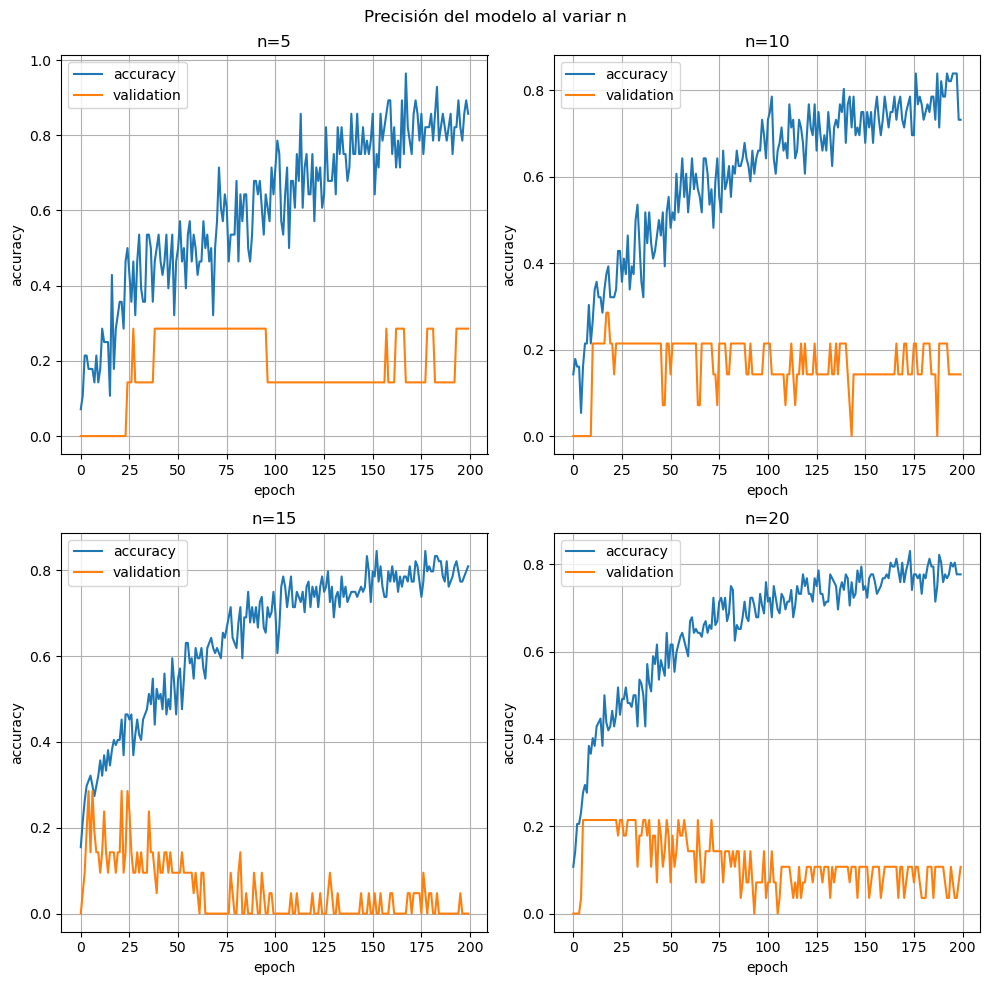

In [47]:
#Vemos para la variación de muestras por elemento
n_peaks=[5,10,15,20]
#Vamos a realizar el entrenamiento para 200 épocas
plt.figure(figsize=(10,10))
plt.suptitle("Precisión del modelo al variar n")
ngraph=1
for n in n_peaks:
    print("n° picos tomados por elemento:",n)
    ltot,Irtot,y=[],[],[]
    ltot,Irtot,y=peak_extraction(0,4,['H'],[ltot,Irtot,y],n)
    ltot,Irtot,y=peak_extraction(1,5,['He','Na','Kr','Hg','Ne','Ar'],[ltot,Irtot,y],n)

    #Los convertimos en datos de entrenamiento para el modelo
    X_train,y_train,sc,le=scaler(ltot,Irtot,y)

    #Creamos la red neuronal. Parámetros de la misma:
    #Entrada: input_dim, units, kernel_initializer, activation
    #Capas ocultas: cantidad, units, kernel_initializer, activation, dropout
    #Salida: units, kernel_initializer, activation
    #Compilación: optimizer, loss, metrics
    #Fit: X_train, y_train, batch_size, epochs, validation_split, verbose
    #Predict: X_test, y_test
    input_par=[2,64,'uniform','relu']
    hide_par=[3,64,'he_uniform','relu',0.2]
    output_par=[7,'uniform','softmax']
    comp_par=['adam','sparse_categorical_crossentropy',['accuracy']]
    fit_par=[X_train,y_train,5,200,0.2,0]
    predict_par=[X_test,y_test]

    #Inicializo red
    net=ClassifierNetwork(input_par, hide_par, output_par, comp_par, fit_par, predict_par)
    #Capa de entrada
    classifier=net.input_layer()
    #Capas ocultas
    classifier=net.hidden_layers()
    #Capas de salida
    classifier=net.output_layer()
    #Compilar modelo
    classifier=net.Compile()
    #Entrenar modelo
    historial, classifier=net.Train()

    #Gráficos de la precisión del modelo para cada valor de "n"
    plt.subplot(2,2,ngraph)
    plt.title(f'n={n}')
    plt.plot(historial.history['accuracy'],label='accuracy')
    plt.plot(historial.history['val_accuracy'],label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend()
    ngraph+=1
    
plt.tight_layout()
plt.show()

<p>La precisión no aumenta demasiado al incrementar los datos tabulados por elemento. En las redes de clasificación no necesariamente se obtienen mejores predicciones con más datos de entrenamiento, y ocasionalmente los mismos pueden diversificarlas, bajando la precisión. <br>
La precisión del modelo oscila alrededor de 80%, por lo cual deberían observarse buenas predicciones.</p>

n° épocas: 100
Número total de picos extraídos: 20
Número total de picos extraídos: 140
Finalizado el escalado de datos. X_train.shape=(140, 2)
Red inicializada.
Capa inicial añadida.
3 Capas ocultas añadidas
Capa de salida añadida.
La red terminó de compilar.
Ha terminado la fase de entrenamiento.
n° épocas: 500
Número total de picos extraídos: 20
Número total de picos extraídos: 140
Finalizado el escalado de datos. X_train.shape=(140, 2)
Red inicializada.
Capa inicial añadida.
3 Capas ocultas añadidas
Capa de salida añadida.
La red terminó de compilar.
Ha terminado la fase de entrenamiento.
n° épocas: 1000
Número total de picos extraídos: 20
Número total de picos extraídos: 140
Finalizado el escalado de datos. X_train.shape=(140, 2)
Red inicializada.
Capa inicial añadida.
3 Capas ocultas añadidas
Capa de salida añadida.
La red terminó de compilar.
Ha terminado la fase de entrenamiento.
n° épocas: 2000
Número total de picos extraídos: 20
Número total de picos extraídos: 140
Finalizado

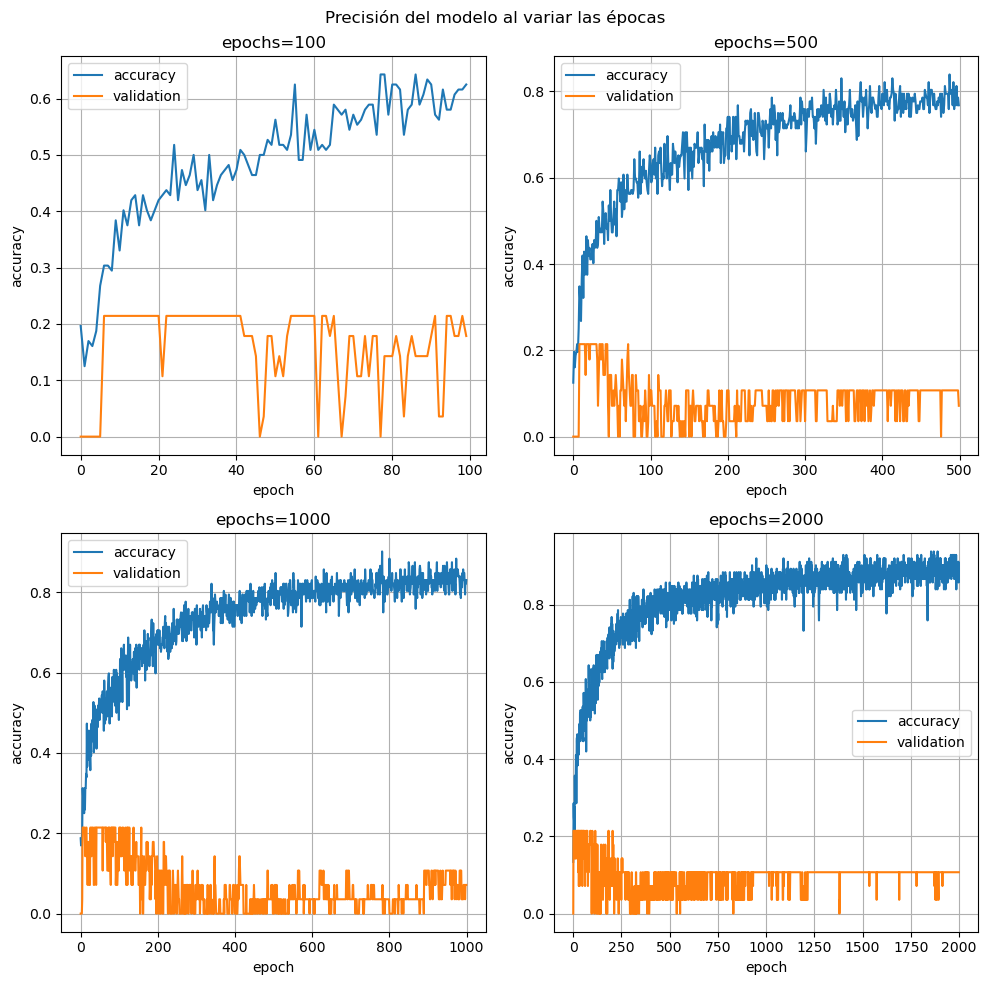

In [115]:
#Vemos el entrenamiento para la variación de épocas (de 100 a 2000)
#IMPORTANTE: AQUI NO SE USO LA FUNCION EarlyStopping en el entrenamiento para no regular las épocas
#Las muestras por elemento van a ser 20
epocas=[100,500,1000,2000]

#Parámetros de los gráficos
plt.figure(figsize=(10,10))
plt.suptitle("Precisión del modelo al variar las épocas")
ngraph=1
for e in epocas:
    print("n° épocas:",e)
    ltot,Irtot,y=[],[],[]
    ltot,Irtot,y=peak_extraction(0,4,['H'],[ltot,Irtot,y],20)
    ltot,Irtot,y=peak_extraction(1,5,['He','Na','Kr','Hg','Ne','Ar'],[ltot,Irtot,y],20)

    #Los convertimos en datos de entrenamiento para el modelo
    X_train,y_train,sc,le=scaler(ltot,Irtot,y)

    #Creamos la red neuronal. Parámetros de la misma:
    #Entrada: input_dim, units, kernel_initializer, activation
    #Capas ocultas: cantidad, units, kernel_initializer, activation, dropout
    #Salida: units, kernel_initializer, activation
    #Compilación: optimizer, loss, metrics
    #Fit: X_train, y_train, batch_size, epochs, validation_split, verbose
    #Predict: X_test, y_test
    input_par=[2,64,'uniform','relu']
    hide_par=[3,64,'he_uniform','relu',0.2]
    output_par=[7,'uniform','softmax']
    comp_par=['adam','sparse_categorical_crossentropy',['accuracy']]
    fit_par=[X_train,y_train,5,e,0.2,0]
    predict_par=[X_test,y_test]

    #Inicializo red
    net=ClassifierNetwork(input_par, hide_par, output_par, comp_par, fit_par, predict_par)
    #Capa de entrada
    classifier=net.input_layer()
    #Capas ocultas
    classifier=net.hidden_layers()
    #Capas de salida
    classifier=net.output_layer()
    #Compilar modelo
    classifier=net.Compile()
    #Entrenar modelo
    historial, classifier=net.Train()

    #Gráficos de la precisión del modelo para cada valor de "n"
    plt.subplot(2,2,ngraph)
    plt.title(f'epochs={e}')
    plt.plot(historial.history['accuracy'],label='accuracy')
    plt.plot(historial.history['val_accuracy'],label='validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend()
    ngraph+=1
    
plt.tight_layout()
plt.show()

<p>La precisión del modelo incrementa al aumentar las épocas. Esto sucede lógicamente porque la red puede actualizar los pesos más veces, y entonces estos ajustan mejor a los datos.</p>
<p>Sin embargo, la pérdida de entrenamiento baja pero la de validación sube a partir de epochs=200 aproximadamente. Por este motivo para impedir el sobreajuste, se utilizó la función EarlyStopping para detener el entrenamiento si la pérdida aumenta.</p>
<p>No se observa sobreajuste si se realizan 200 épocas para el entrenamiento.</p>

<h1>Predicciones sobre datos tabulados</h1>
<p>Se tomó la configuración óptima de 22 muestras por elemento, con 1000 épocas para evitar sobreajuste. Los datos de prueba fueron el 30% de los tabulados totales.</p>

Número total de picos extraídos: 22
Número total de picos extraídos: 154
Finalizado el escalado de datos. X_train.shape=(154, 2)
X_train.shape= (107, 2)
X_test.shape= (47, 2)
y_train.shape= (107,)
y_test.shape= (47,)
Red inicializada.
Capa inicial añadida.
3 Capas ocultas añadidas
Capa de salida añadida.
La red terminó de compilar.
Ha terminado la fase de entrenamiento.
Tiempo de entrenamiento: 67.2342 segundos o 1:7 min:seg
2/2 [==============================] - 0s 0s/step
Se ha realizado la predicción.


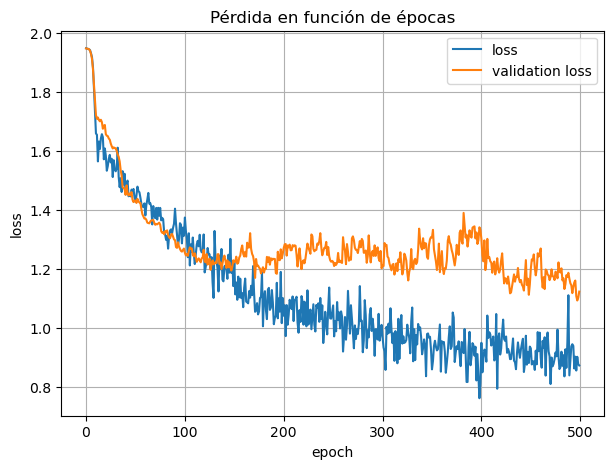

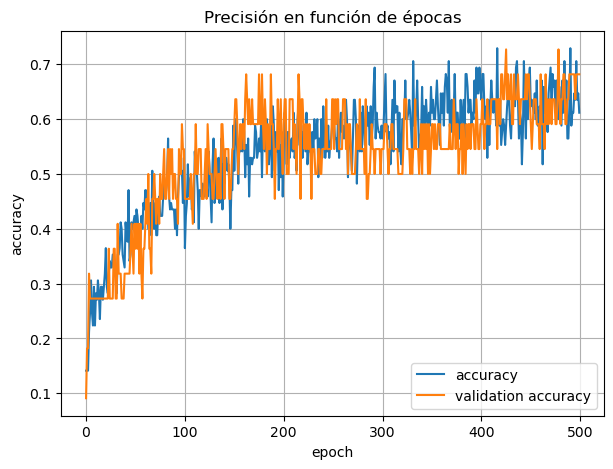

In [117]:
#Primero utilizaremos un 70% de los datos tabulados para entrenar el modelo y luego un 30% para testear el mismo

#Preprocesado de datos tabulados
ltot,Irtot,y=[],[],[]
ltot,Irtot,y=peak_extraction(0,4,['H'],[ltot,Irtot,y],22)
ltot,Irtot,y=peak_extraction(1,5,['He','Na','Kr','Hg','Ne','Ar'],[ltot,Irtot,y],22)

#Escalado
X,y,sc,le=scaler(ltot,Irtot,y)

#División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,# 30% para test
                                                    random_state=42,# para reproducibilidad
                                                    stratify=y)# opcional, para balancear clases

print("X_train.shape=",X_train.shape)
print("X_test.shape=",X_test.shape)
print("y_train.shape=",y_train.shape)
print("y_test.shape=",y_test.shape)

#Creamos la red neuronal. Parámetros de la misma:
#Entrada: input_dim, units, kernel_initializer, activation
#Capas ocultas: cantidad, units, kernel_initializer, activation, dropout
#Salida: units, kernel_initializer, activation
#Compilación: optimizer, loss, metrics
#Fit: X_train, y_train, batch_size, epochs, validation_split, verbose
#Predict: X_test, y_test
input_par=[2,32,'uniform','relu']
hide_par=[3,32,'he_uniform','relu',0.2]
output_par=[7,'uniform','softmax']
comp_par=['adam','sparse_categorical_crossentropy',['accuracy']]
fit_par=[X_train,y_train,5,500,0.2,0]
predict_par=[X_test,y_test]

#Inicializo red
net=ClassifierNetwork(input_par, hide_par, output_par, comp_par, fit_par, predict_par)
#Capa de entrada
classifier=net.input_layer()
#Capas ocultas
classifier=net.hidden_layers()
#Capas de salida
classifier=net.output_layer()
#Compilar modelo
classifier=net.Compile()
#Entrenar modelo
inicio = time.perf_counter()
historial, classifier=net.Train()
fin = time.perf_counter()
print(f"Tiempo de entrenamiento: {fin - inicio:.4f} segundos o {int((fin-inicio)/60)}:{int((fin-inicio)%60)} min:seg")


#Predicciones sobre los datos experimentales
y_pred, classifier=net.Predict()


#Ploteo de la pérdida en función de las épocas (curva de aprendizaje)
plt.figure(figsize=(7,5))
plt.title('Pérdida en función de épocas')
plt.plot(historial.history['loss'],label='loss')
plt.plot(historial.history['val_loss'],label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

#Ploteo de la precisión del modelo
plt.figure(figsize=(7,5))
plt.title('Precisión en función de épocas')
plt.plot(historial.history['accuracy'],label='accuracy')
plt.plot(historial.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()

[2 5 2 1 6 6 6 1 4 4 4 5 2 3 6 6 2 3 5 5 4 3 0 0 1 2 1 5 4 6 4 3 3 3 0 6 2
 5 1 4 5 0 1 0 0 3 2] 47
[5 5 5 1 6 0 0 1 4 4 0 5 2 5 0 4 4 1 5 5 0 3 6 0 1 3 1 0 4 0 4 3 6 5 0 6 2
 5 1 4 5 4 1 0 6 5 4] 47


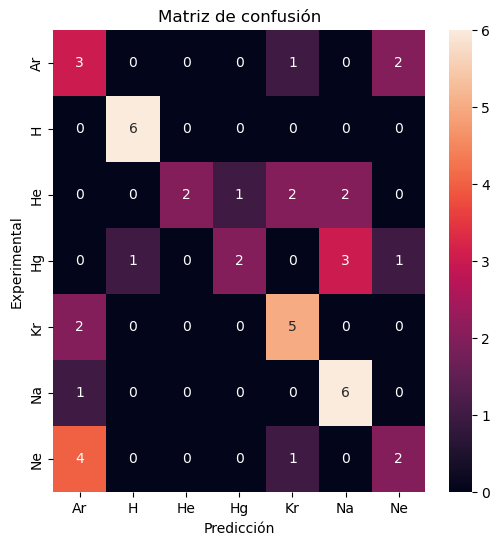

              precision    recall  f1-score   support

          Ar       0.30      0.50      0.37         6
           H       0.86      1.00      0.92         6
          He       1.00      0.29      0.44         7
          Hg       0.67      0.29      0.40         7
          Kr       0.56      0.71      0.63         7
          Na       0.55      0.86      0.67         7
          Ne       0.40      0.29      0.33         7

    accuracy                           0.55        47
   macro avg       0.62      0.56      0.54        47
weighted avg       0.62      0.55      0.53        47



In [118]:
#Ploteo de la matriz de confusión
net.plot_confusion_matrix(y_test,y_pred,le)

y_pred_max=np.argmax(y_pred,axis=1)

#Reporte con la información relevante con respecto a las predicciones
print(classification_report(y_test, y_pred_max, target_names=le.classes_, zero_division=1))

<p>Se puede observar que las predicciones son bastante imprecisas, sobre todo en los elementos Hg, Ne y He, en Kr se clasificaron bien 5, y en Na y H fueron todos bien clasificados.</p>
<p>Cabe mencionar que algunos de estos picos de un espectro se solapan con los de otro, por lo que es normal que puedan darse estas imprecisiones en el modelo.</p>

<h1>Predicciones sobre datos experimentales</h1>
<p>Se tomó la configuración óptima de 22 muestras por elemento, con 1000 épocas (la función EarlyStopping regula las épocas necesarias para evitar sobreajuste). Los datos de prueba fueron los experimentales (mediciones realizadas con un filtro Thorlabs).</p>

Número total de picos extraídos: 22
Número total de picos extraídos: 154
Finalizado el escalado de datos. X_train.shape=(154, 2)
Finalizado el escalado de datos. X_test.shape=(56, 2)
y_test= [1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 4 4 4 4
 4 4 4 4 4 3 3 3 3 3 3 3 0 0 0 0 0 0 0]
Red inicializada.
Capa inicial añadida.
2 Capas ocultas añadidas
Capa de salida añadida.
La red terminó de compilar.
Ha terminado la fase de entrenamiento.
Tiempo de entrenamiento: 33.5148 segundos o 0:33 min:seg
2/2 [==============================] - 0s 9ms/step
Se ha realizado la predicción.


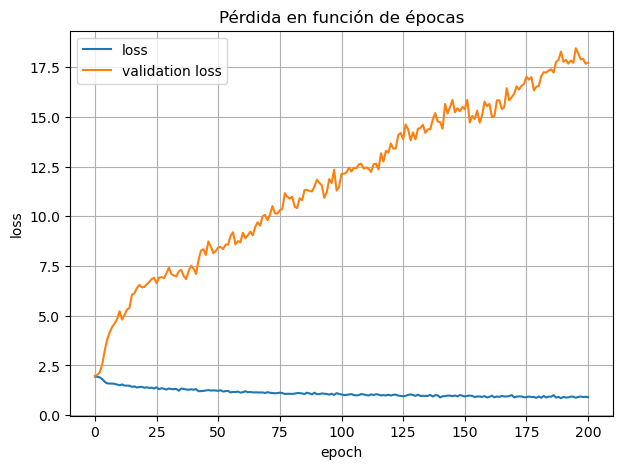

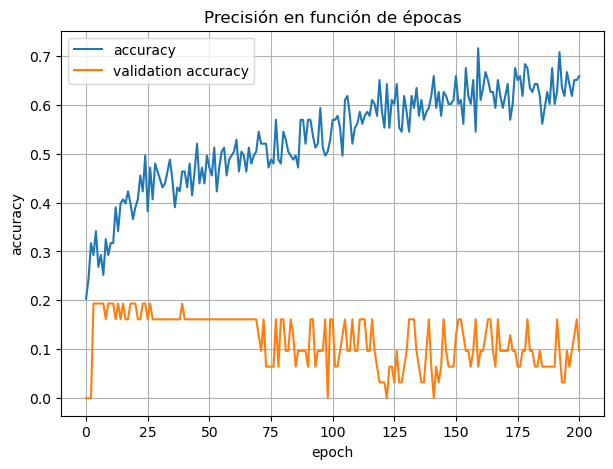

In [119]:
#Preprocesado de datos tabulados
ltot,Irtot,y=[],[],[]
ltot,Irtot,y=peak_extraction(0,4,['H'],[ltot,Irtot,y],22)
ltot,Irtot,y=peak_extraction(1,5,['He','Na','Kr','Hg','Ne','Ar'],[ltot,Irtot,y],22)

#Los convertimos en datos de entrenamiento para el modelo
X_train,y_train,sc,le=scaler(ltot,Irtot,y)

#Parámetros para obtener los picos para cada elemento
par=[[0.028,10,1e-6],[1.0,250,1.0],[1.0,300,1.0],[0.8,10,0.8],[0.3,10,0.18],[0.5,5,0.4],[0.8,10,0.4]]
#Preprocesado de datos experimentales
#Vamos a usar los espectros experimentales
espectral_list=['H','He','Ne','Na','Kr','Hg','Ar']
#espectral_list=['H','Na','Ne']
lexptot,Irexptot,yexptot=[],[],[]
for i in range(len(espectral_list)):

    param=par[i]
    
    ms1=[50,100,150,200]
    #ms1=[50]
    ms2=[200,300,400,500]
    #ms2=[200]
    ms3=[50,100,200,300]
    #ms3=[50]
    
    #El Kr y el Ar son los únicos en el que se midieron distintos valores de ms (escala del software)
    if i!=4 and i!=6:
        ms=ms1
    elif i==4:
        ms=ms2
    else:
        ms=ms3

    #Obtengo los picos para cada escala ms
    for m in ms:
        espectro=f'lamp{espectral_list[i]} {m} ms'
    
        lexp,Irexp=clean_espectral_data(f"dataset espectroscopia/dataset test/{espectro}.csv")

        #Normalizamos
        Irexp/=np.max(Irexp)

        #Parámetros
        lexptot,Irexptot,yexptot=experimental_peaks(lexp,Irexp,[lexptot,Irexptot,yexptot],espectral_list[i],*param)
    
#Escalado
X_test,y_test,sc,le=scaler_test(lexptot,Irexptot,yexptot,sc,le)
print("y_test=",y_test)



#Creamos la red neuronal. Parámetros de la misma:
#Entrada: input_dim, units, kernel_initializer, activation
#Capas ocultas: cantidad, units, kernel_initializer, activation, dropout
#Salida: units, kernel_initializer, activation
#Compilación: optimizer, loss, metrics
#Fit: X_train, y_train, batch_size, epochs, validation_split, verbose
#Predict: X_test, y_test
input_par=[2,X_train.shape[0],'uniform','relu']
hide_par=[2,32,'he_uniform','relu',0.2]
output_par=[7,'uniform','softmax']
comp_par=['adam','sparse_categorical_crossentropy',['accuracy']]
fit_par=[X_train,y_train,5,500,0.2,0]
predict_par=[X_test,y_test]

#Inicializo red
net=ClassifierNetwork(input_par, hide_par, output_par, comp_par, fit_par, predict_par)
#Capa de entrada
classifier=net.input_layer()
#Capas ocultas
classifier=net.hidden_layers()
#Capas de salida
classifier=net.output_layer()
#Compilar modelo
classifier=net.Compile()
#Entrenar modelo
inicio = time.perf_counter()
historial, classifier=net.Train()
fin = time.perf_counter()
print(f"Tiempo de entrenamiento: {fin - inicio:.4f} segundos o {int((fin-inicio)/60)}:{int((fin-inicio)%60)} min:seg")


#Predicciones sobre los datos experimentales
y_pred, classifier=net.Predict()


#Ploteo de la pérdida en función de las épocas (curva de aprendizaje)
plt.figure(figsize=(7,5))
plt.title('Pérdida en función de épocas')
plt.plot(historial.history['loss'],label='loss')
plt.plot(historial.history['val_loss'],label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

#Ploteo de la precisión del modelo
plt.figure(figsize=(7,5))
plt.title('Precisión en función de épocas')
plt.plot(historial.history['accuracy'],label='accuracy')
plt.plot(historial.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()

<p>La pérdida aumenta para la validación, clara muestra de sobreajuste.</p>

[1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 4 4 4 4
 4 4 4 4 4 3 3 3 3 3 3 3 0 0 0 0 0 0 0] 56
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1] 56


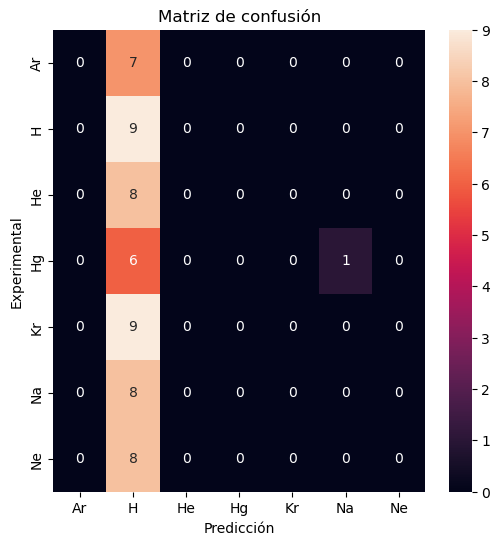

              precision    recall  f1-score   support

          Ar       1.00      0.00      0.00         7
           H       0.16      1.00      0.28         9
          He       1.00      0.00      0.00         8
          Hg       1.00      0.00      0.00         7
          Kr       1.00      0.00      0.00         9
          Na       0.00      0.00      1.00         8
          Ne       1.00      0.00      0.00         8

    accuracy                           0.16        56
   macro avg       0.74      0.14      0.18        56
weighted avg       0.72      0.16      0.19        56



In [120]:
#Ploteo de la matriz de confusión
net.plot_confusion_matrix(y_test,y_pred,le)

y_pred_max=np.argmax(y_pred,axis=1)

#Reporte con la información relevante con respecto a las predicciones
print(classification_report(y_test, y_pred_max, target_names=le.classes_, zero_division=1))

<h1>Conclusiones parciales:</h1>
<p>Se puede observar que en los datos experimentales, los picos medidos discrepan con respecto a los tabulados en la mayoría de los casos, lo cual afectó a la precisión de la predicción. Al predecir con el modelo el elemento al cual pertenecen los máximos experimentales, la matriz de confusión muestra que el mismo modelo suele confundir clases.</p>
<p>Una posible causa de que las predicciones resultaran deficientes fue que algunos de los espectros medidos en laboratorio presentaron saturación (la intensidad a veces sobrepasaba la escala del filtro), por lo que no se encontraron picos prominentes con respecto a longitudes de onda cercanas.</p>
<p>Una corrección a futuro podría ser el obtener datos experimentales más precisos y no saturados en parte. También podrían tomarse picos tabulados provenientes de más fuentes o más columnas de datos (en este script uso 2: lambda e I) para mejorar el entrenamiento del modelo.</p>

<h1>Análisis de espectros con otra configuración</h1>
<ul>
    <li>Descartamos los datos de He para el entrenamiento, pues la cantidad de datos tabulados no excede 22, y se precisan más datos.</li>
    <li>Descartamos los datos de Ne y Na para el entrenamiento, pues los espectros experimentales muestran saturación y no son óptimos para las predicciones.</li>
    <li>El número de picos tabulados de H en el rango de 200-1100 nm es 62, por lo que tomamos este valor para todos los elementos para balancear las clases.</li>
</ul>

<h3>Predicción del modelo utilizando solo datos tabulados.</h3>

Número total de picos extraídos: 62
Número total de picos extraídos: 248
Finalizado el escalado de datos. X_train.shape=(248, 2)
X_train.shape= (173, 2)
X_test.shape= (75, 2)
y_train.shape= (173,)
y_test.shape= (75,)
Red inicializada.
Capa inicial añadida.
3 Capas ocultas añadidas
Capa de salida añadida.
La red terminó de compilar.
Ha terminado la fase de entrenamiento.
Tiempo de entrenamiento: 84.2538 segundos o 1:24 min:seg
3/3 [==============================] - 0s 5ms/step
Se ha realizado la predicción.


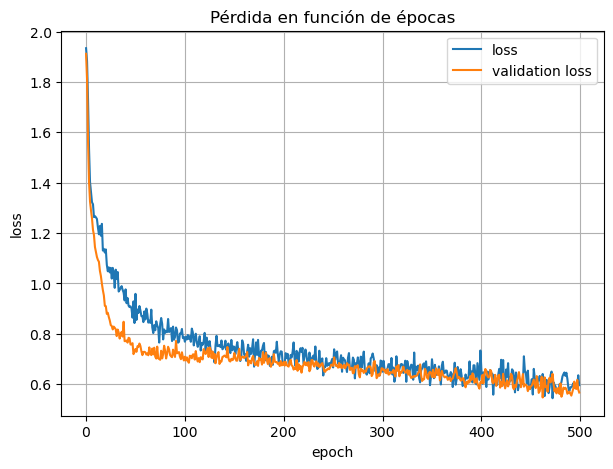

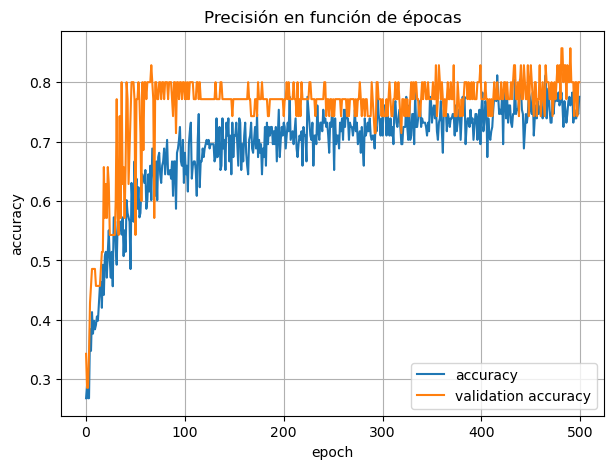

In [121]:
#Primero utilizaremos un 70% de los datos tabulados para entrenar el modelo y luego un 30% para testear el mismo

#Preprocesado de datos tabulados
ltot,Irtot,y=[],[],[]
ltot,Irtot,y=peak_extraction(0,4,['H'],[ltot,Irtot,y],62)
ltot,Irtot,y=peak_extraction(1,5,['Kr','Hg','Ar'],[ltot,Irtot,y],62)

#Escalado
X,y,sc,le=scaler(ltot,Irtot,y)

#División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,# 30% para test
                                                    random_state=42,# para reproducibilidad
                                                    stratify=y)# opcional, para balancear clases

print("X_train.shape=",X_train.shape)
print("X_test.shape=",X_test.shape)
print("y_train.shape=",y_train.shape)
print("y_test.shape=",y_test.shape)

#Creamos la red neuronal. Parámetros de la misma:
#Entrada: input_dim, units, kernel_initializer, activation
#Capas ocultas: cantidad, units, kernel_initializer, activation, dropout
#Salida: units, kernel_initializer, activation
#Compilación: optimizer, loss, metrics
#Fit: X_train, y_train, batch_size, epochs, validation_split, verbose
#Predict: X_test, y_test
input_par=[2,32,'uniform','relu']
hide_par=[3,32,'he_uniform','relu',0.2]
output_par=[7,'uniform','softmax']
comp_par=['adam','sparse_categorical_crossentropy',['accuracy']]
fit_par=[X_train,y_train,5,500,0.2,0]
predict_par=[X_test,y_test]

#Inicializo red
net=ClassifierNetwork(input_par, hide_par, output_par, comp_par, fit_par, predict_par)
#Capa de entrada
classifier=net.input_layer()
#Capas ocultas
classifier=net.hidden_layers()
#Capas de salida
classifier=net.output_layer()
#Compilar modelo
classifier=net.Compile()
#Entrenar modelo
inicio = time.perf_counter()
historial, classifier=net.Train()
fin = time.perf_counter()
print(f"Tiempo de entrenamiento: {fin - inicio:.4f} segundos o {int((fin-inicio)/60)}:{int((fin-inicio)%60)} min:seg")


#Predicciones sobre los datos experimentales
y_pred, classifier=net.Predict()


#Ploteo de la pérdida en función de las épocas (curva de aprendizaje)
plt.figure(figsize=(7,5))
plt.title('Pérdida en función de épocas')
plt.plot(historial.history['loss'],label='loss')
plt.plot(historial.history['val_loss'],label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

#Ploteo de la precisión del modelo
plt.figure(figsize=(7,5))
plt.title('Precisión en función de épocas')
plt.plot(historial.history['accuracy'],label='accuracy')
plt.plot(historial.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()

<p>Se puede observar que, al eliminar 3 elementos de los 7 y tomar más puntos por elemento, la precisión de validación incrementó considerablemente.</p>

[3 1 0 0 1 1 3 0 1 2 2 3 0 1 0 3 3 0 1 2 0 0 1 2 3 2 2 1 3 3 0 2 1 0 2 2 2
 3 3 0 1 1 0 2 3 2 2 3 1 2 1 1 2 3 0 3 0 0 1 2 3 1 1 3 3 3 3 0 0 1 0 0 2 2
 2] 75
[3 1 2 3 1 2 3 0 2 3 2 3 0 1 0 3 3 0 1 2 0 0 1 2 3 2 2 1 3 3 0 2 3 3 2 2 2
 3 3 0 3 1 0 2 3 2 0 3 1 2 1 1 1 3 3 3 0 3 1 2 3 1 1 0 3 3 3 0 2 3 0 3 2 3
 2] 75


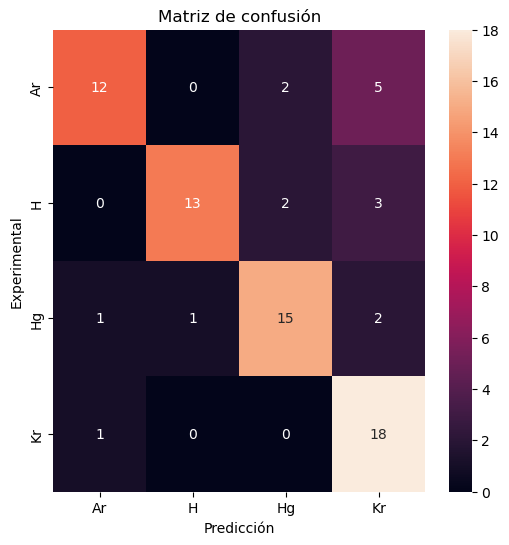

              precision    recall  f1-score   support

          Ar       0.86      0.63      0.73        19
           H       0.93      0.72      0.81        18
          Hg       0.79      0.79      0.79        19
          Kr       0.64      0.95      0.77        19

    accuracy                           0.77        75
   macro avg       0.80      0.77      0.77        75
weighted avg       0.80      0.77      0.77        75



In [122]:
#Ploteo de la matriz de confusión
net.plot_confusion_matrix(y_test,y_pred,le)

y_pred_max=np.argmax(y_pred,axis=1)

#Reporte con la información relevante con respecto a las predicciones
print(classification_report(y_test, y_pred_max, target_names=le.classes_, zero_division=1))

<p>El resultado del entrenamiento y prueba del modelo se ve reflejado en la matriz de confusión, donde los aciertos son mucho mayores.</p>

<h3>Predicción del modelo utilizando como datos de prueba los experimentales.</h3>

Número total de picos extraídos: 62
Número total de picos extraídos: 248
Finalizado el escalado de datos. X_train.shape=(248, 2)
Finalizado el escalado de datos. X_test.shape=(32, 2)
y_test= [1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 0 0 0 0 0 0 0]
Red inicializada.
Capa inicial añadida.
3 Capas ocultas añadidas
Capa de salida añadida.
La red terminó de compilar.
Ha terminado la fase de entrenamiento.
Tiempo de entrenamiento: 43.6007 segundos o 0:43 min:seg
1/1 [==============================] - 0s 205ms/step
Se ha realizado la predicción.


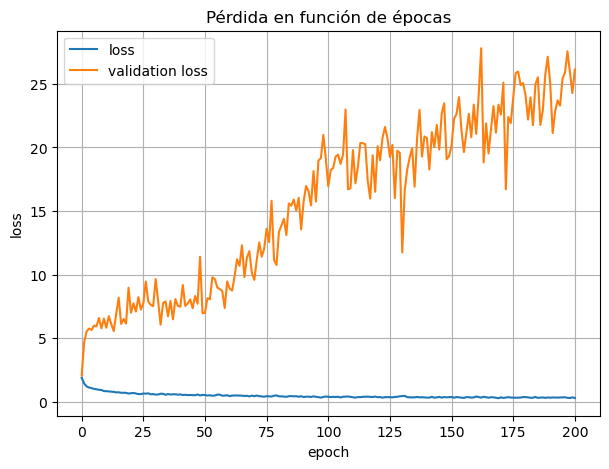

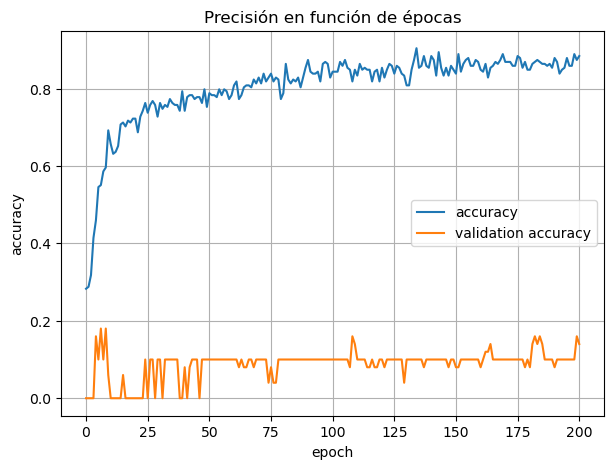

In [127]:
#Preprocesado de datos tabulados
ltot,Irtot,y=[],[],[]
ltot,Irtot,y=peak_extraction(0,4,['H'],[ltot,Irtot,y],62)
ltot,Irtot,y=peak_extraction(1,5,['Kr','Hg','Ar'],[ltot,Irtot,y],62)

#Los convertimos en datos de entrenamiento para el modelo
X_train,y_train,sc,le=scaler(ltot,Irtot,y)

#Parámetros para obtener los picos para cada elemento
par=[[0.028,10,1e-6],[0.3,10,0.18],[0.5,5,0.4],[0.8,10,0.4]]
#Preprocesado de datos experimentales
#Vamos a usar los espectros experimentales
espectral_list=['H','Kr','Hg','Ar']
lexptot,Irexptot,yexptot=[],[],[]
for i in range(len(espectral_list)):

    param=par[i]
    
    ms1=[50,100,150,200]
    #ms1=[50]
    ms2=[200,300,400,500]
    #ms2=[200]
    ms3=[50,100,200,300]
    #ms3=[50]
    
    #El Kr y el Ar son los únicos en los que se midieron para distintos valores de ms (escala del software)
    if i!=1 and i!=3:
        ms=ms1
    elif i==1:
        ms=ms2
    else:
        ms=ms3

    #Obtengo los picos para cada escala ms
    for m in ms:
        espectro=f'lamp{espectral_list[i]} {m} ms'
    
        lexp,Irexp=clean_espectral_data(f"dataset espectroscopia/dataset test/{espectro}.csv")

        #Normalizamos
        Irexp/=np.max(Irexp)

        #Parámetros
        lexptot,Irexptot,yexptot=experimental_peaks(lexp,Irexp,[lexptot,Irexptot,yexptot],espectral_list[i],*param)
    
#Escalado
X_test,y_test,sc,le=scaler_test(lexptot,Irexptot,yexptot,sc,le)
print("y_test=",y_test)



#Creamos la red neuronal. Parámetros de la misma:
#Entrada: input_dim, units, kernel_initializer, activation
#Capas ocultas: cantidad, units, kernel_initializer, activation, dropout
#Salida: units, kernel_initializer, activation
#Compilación: optimizer, loss, metrics
#Fit: X_train, y_train, batch_size, epochs, validation_split, verbose
#Predict: X_test, y_test
input_par=[2,X_train.shape[0],'uniform','relu']
hide_par=[3,64,'he_uniform','relu',0.3]
output_par=[7,'uniform','softmax']
comp_par=['adam','sparse_categorical_crossentropy',['accuracy']]
fit_par=[X_train,y_train,5,500,0.2,0]
predict_par=[X_test,y_test]

#Inicializo red
net=ClassifierNetwork(input_par, hide_par, output_par, comp_par, fit_par, predict_par)
#Capa de entrada
classifier=net.input_layer()
#Capas ocultas
classifier=net.hidden_layers()
#Capas de salida
classifier=net.output_layer()
#Compilar modelo
classifier=net.Compile()
#Entrenar modelo
inicio = time.perf_counter()
historial, classifier=net.Train()
fin = time.perf_counter()
print(f"Tiempo de entrenamiento: {fin - inicio:.4f} segundos o {int((fin-inicio)/60)}:{int((fin-inicio)%60)} min:seg")


#Predicciones sobre los datos experimentales
y_pred, classifier=net.Predict()


#Ploteo de la pérdida en función de las épocas (curva de aprendizaje)
plt.figure(figsize=(7,5))
plt.title('Pérdida en función de épocas')
plt.plot(historial.history['loss'],label='loss')
plt.plot(historial.history['val_loss'],label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

#Ploteo de la precisión del modelo
plt.figure(figsize=(7,5))
plt.title('Precisión en función de épocas')
plt.plot(historial.history['accuracy'],label='accuracy')
plt.plot(historial.history['val_accuracy'],label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()

[1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 0 0 0 0 0 0 0] 32
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 32


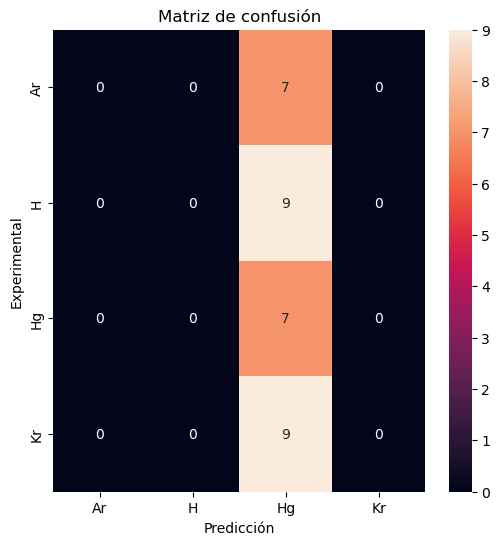

              precision    recall  f1-score   support

          Ar       1.00      0.00      0.00         7
           H       1.00      0.00      0.00         9
          Hg       0.22      1.00      0.36         7
          Kr       1.00      0.00      0.00         9

    accuracy                           0.22        32
   macro avg       0.80      0.25      0.09        32
weighted avg       0.83      0.22      0.08        32



In [128]:
#Ploteo de la matriz de confusión
net.plot_confusion_matrix(y_test,y_pred,le)

y_pred_max=np.argmax(y_pred,axis=1)

#Reporte con la información relevante con respecto a las predicciones
print(classification_report(y_test, y_pred_max, target_names=le.classes_, zero_division=1))

<p>Las predicciones sobre los datos experimentales no son acertadas. En la celda siguiente se hace una comparación entre los espectros tabulados y los medidos.</p>

<h3>Selección de picos experimentales y comparación con los tabulados.</h3>

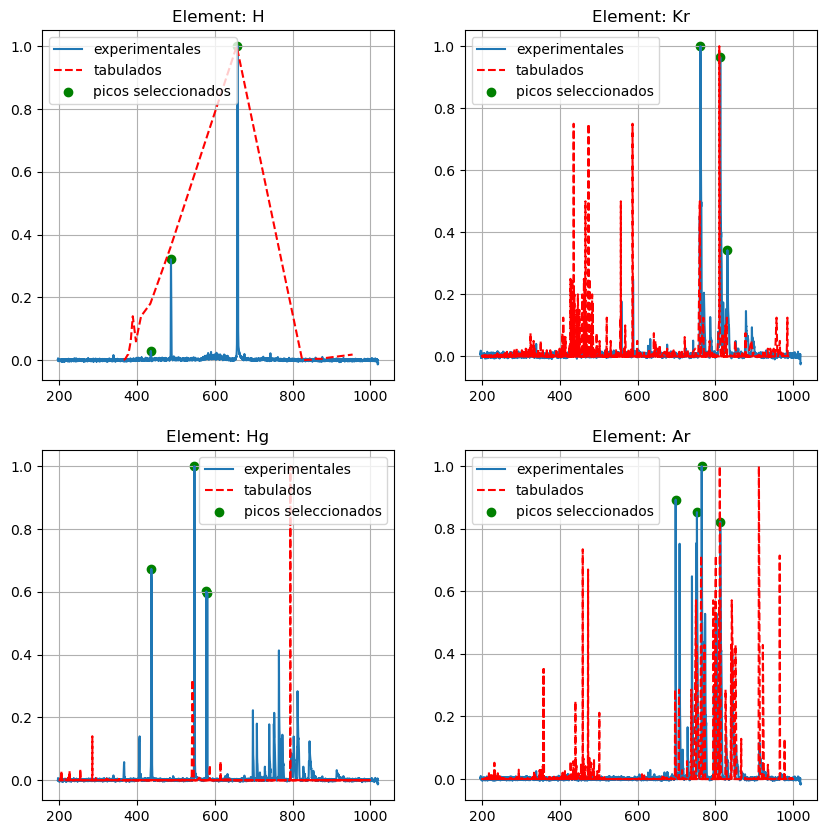

In [104]:
#Los picos seleccionados experimentalmente se obtuvieron cambiando los parámetros
par=[[0.028,10,1e-6],[0.3,10,0.18],[0.5,5,0.4],[0.8,10,0.4]]
#Preprocesado de datos experimentales
#Vamos a usar los espectros experimentales
espectral_list=['H','Kr','Hg','Ar']
#espectral_list=['H','Na','Ne']
lexptot,Irexptot,yexptot=[],[],[]
lamb,Irel=[],[]

plt.figure(figsize=(10,10))
ngraph=1
for i in range(len(espectral_list)):

    param=par[i]

    #Seleccionamos solo una escala para graficar los espectros
    ms1=[200]
    #ms1=[50]
    ms2=[500]
    #ms2=[200]
    ms3=[300]
    #ms3=[50]
    
    #El Kr y el Ar son los únicos en el que se midieron distintos valores de ms (escala del software)
    if i!=1 and i!=3:
        ms=ms1
    elif i==1:
        ms=ms2
    else:
        ms=ms3

    #Obtengo los picos para cada escala ms
    for m in ms:
        espectro=f'lamp{espectral_list[i]} {m} ms'
    
        lexp,Irexp=clean_espectral_data(f"dataset espectroscopia/dataset test/{espectro}.csv")

        #Normalizamos
        Irexp/=np.max(Irexp)

        #Parámetros
        lexptot,Irexptot,yexptot=experimental_peaks(lexp,Irexp,[lexptot,Irexptot,yexptot],espectral_list[i],*param)

    #Datos tabulados
    if i==0:
        data=pd.read_excel(f"dataset espectroscopia/dataset train/Picos emision {espectral_list[i]}.xlsx")
        
        lrow=pd.to_numeric(data.iloc[:,0],errors='coerce')
        Irow=pd.to_numeric(data.iloc[:,4],errors='coerce')
        
        for j in range(len(lrow)):
            #Verificación de datos NaN
            if (np.isnan(lrow[j]) or np.isnan(Irow[j])):
                continue
            else:

                #El rango de longitudes de onda será de 200nm a 1100nm (similar a los datos de prueba)
                if (lrow[j]>200 and lrow[j]<1100):
            
                    lamb=np.append(lamb,lrow[j])
                    #Algunos valores de I son negativos, por lo que se debe de tomar módulo
                    Irel=np.append(Irel,abs(Irow[j]))
    

        #Se deben normalizar los datos de intensidad dividiendo por el máximo
        Irel/=max(Irel)
        
    else:
        data=pd.read_excel(f"dataset espectroscopia/dataset train/Picos emision {espectral_list[i]}.xlsx")
        
        lrow=pd.to_numeric(data.iloc[:,1],errors='coerce')
        Irow=pd.to_numeric(data.iloc[:,5],errors='coerce')
        
        for j in range(len(lrow)):
            #Verificación de datos NaN
            if (np.isnan(lrow[j]) or np.isnan(Irow[j])):
                continue
            else:

                #El rango de longitudes de onda será de 200nm a 1100nm (similar a los datos de prueba)
                if (lrow[j]>200 and lrow[j]<1100):
            
                    lamb=np.append(lamb,lrow[j])
                    #Algunos valores de I son negativos, por lo que se debe de tomar módulo
                    Irel=np.append(Irel,abs(Irow[j]))
    

        #Se deben normalizar los datos de intensidad dividiendo por el máximo
        Irel/=max(Irel)

    plt.subplot(2,2,ngraph)
    plt.title("Element: "+espectral_list[i])
    plt.plot(lexp,Irexp,label='experimentales')
    plt.plot(lamb,Irel,linestyle='--',color='red',label='tabulados')
    plt.scatter(lexptot,Irexptot,color='green',label="picos seleccionados")
    plt.grid()
    plt.legend()
    ngraph+=1
    lexptot,Irexptot,yexptot=[],[],[]
    ltot,Irtot,y=[],[],[]

plt.show()

<h1>Conclusiones:</h1>
<p>El modelo resultó ser eficiente para división de datos tabulados en entrenamiento y prueba, sobretodo cuando se eliminaron clases y se aumentaron los picos por elemento.<br>
Por otra parte, los datos experimentales no coinciden en gran parte con los tabulados, por lo que el modelo no es preciso con estos datos. Probablemente las fuentes de luz de estos espectros no corresponden a los elementos puros, sino que contengan trazas de otros elementos, lo que diversifica el espectro. </p>